# Data wrangling WeRateDogs project

## Introduction

We will do data wrangling for the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates).

## Gathering Data
### Gathering data of twitter-archive-enhanced.csv
* We munally download WeRateDogs from the following [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv).

### Gathering data of image-predictions.tsv
* The tweet image prediction, i.e., what greed of dong(or other object, animal, etc), is downloaded programmatically from the following [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv), which is hosted on Udacity's server

In [32]:
# Download programmatically
import requests
import os

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# Save to file
with open('image-predictions.tsv', 'wb+') as file:
    file.write(response.content)

### Gathering data of tweet_json.txt
* WeRateDogs tweet will be downloaded into tweet_json.txt by using Tweepy, after we register to Twitter's Developer Portal
* Each tweet's retweet count and favorite ("like") count will be used for analysis

In [39]:
import pandas as pd
import tweepy
import json

key = "ZKXGaDrLuWyugH042yBJvC191"
key_secret = "3zVRig5tumibOgV9LiecifT5gP4zDRFl7w0q66QvHaLz2pS0e8"
token = "76198362-yhOiY8Tbcg3IJT2eASbnXQ8fHQ0KRvHRtp3rw4v3q"
token_secret = "bSywULUWxIrixIsF2DquFPgnGSvOX5W9Jn1XWnp2CZToG"

auth = tweepy.OAuthHandler(key, key_secret)
auth.set_access_token(token, token_secret)

api = tweepy.API(auth)

# get tweet ids only. from twitter_archive_enhanced
df_tweet = twitter_archive_enhanced
tweet_ids = list(df_tweet.tweet_id)

tweet_json = {}

for tweet_id in tweet_ids:
    try:
        tweet_status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_json[str(tweet_id)] = tweet_status._json
    except tweepy.TweepError as e:
        print("TweepError tweet_id error: " + str(tweet_id))
        print(e)
    except tweepy.RateLimitError as e:
        print("RateLimitError tweet_id error: " + str(tweet_id))
        print(e)
    except Exception as e:
        print("Exception")
        print(e)
    # there is no exception
    else:
        print("tweet_id : " + str(tweet_id))

# Save json to file
with open('tweet_json.txt', 'w') as file:
    json.dump(tweet_json, file)

tweet_id : 892420643555336193


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8378,38254


# Assessing data

there are three dataframes.
* twitter_archive_enhanced from twitter_archive_enhanced.csv
* image_predictions from image_predictions.tsv
* df_json from by using tweepy API

In [60]:
# Loading three dataframes from csv, tsv and tweet_json.txt

import pandas as pd
import json

twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', encoding='utf-8')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t', encoding='utf-8')

import pandas as pd
import json

# load json to twee_json from file
with open('tweet_json.txt', 'r') as file:
    tweet_json = json.load(file)
    
# Create new dataframe from json file
tweet_id_list = []
retweet_count_list = []
favorite_count_list = []

for tweet_id in tweet_json.keys():
    tweet_id_list.append(tweet_id)
    retweet_count_list.append(tweet_json[tweet_id]['retweet_count'])
    favorite_count_list.append(tweet_json[tweet_id]['favorite_count'])

columns_from_dict = {'tweet_id': tweet_id_list,
                'retweet_count': retweet_count_list,
                'favorite_count': favorite_count_list}    
    
df_json = pd.DataFrame.from_dict(columns_from_dict)
# retweet_count and favorite_count are created into new dataframe as df_json
df_json.to_csv('tweet_json.csv', encoding='utf-8', index=False)

## Tidiness issues #1~2
* Need to join df_json with twitter_archive_enhanced, as tweet_id is a key
* Need to join image_predictions with twitter_archive_enhanced, as tweet_id is a key, also

In [66]:
import pandas as pd

twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', encoding='utf-8')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t', encoding='utf-8')
df_json = pd.read_csv('tweet_json.csv', encoding='utf-8')

# df_json.tweet_id type is not int64, it is object.
# So, to merge two dataframes, it should be converted to int64
new_column = df_json.tweet_id.astype('int64')
df_json.tweet_id = new_column
df = pd.merge(twitter_archive_enhanced, df_json, left_on='tweet_id', right_on='tweet_id')
df = pd.merge(df, image_predictions, left_on='tweet_id', right_on='tweet_id')
df.to_csv('twitter-archive-enhanced_no_tidiness.csv', encoding='utf-8', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 30 columns):
tweet_id                      2068 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2068 non-null object
source                        2068 non-null object
text                          2068 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2068 non-null object
rating_numerator              2068 non-null int64
rating_denominator            2068 non-null int64
name                          2068 non-null object
doggo                         2068 non-null object
floofer                       2068 non-null object
pupper                        2068 non-null object
puppo                         2068 non-null object
retweet_count                 2068 

## Quality issue #1/8 as completeness
* There are 4 missing rows. five row will be missing while we merge two dataframe into one.
 * twitter_archive_enhanced have 2356 rows
 * df_json have 2342 rows.
 
## Quality issue #2/8 as completeness
* image_predictions have 2068 rows, unlike df have 2341
* We will lose some rows from df, some tweet don't have image_predictions rows
* Now, we lost about 300 rows from df due to that they are not exited in image_predictions

## Quality issue #3 ~ 8
* in_reply_to_status_id type should be int64, not float64, as it is according twitter reference below
 * https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
* in_reply_to_user_id type should be int64, not float64, as it is according twitter reference below
 * https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
* timestamp should be string, not object
* name should be string, not object
* jpg_url should be string, not object
* p1, p2, p3 should be string, not object

# Cleaning data

## Define
We should get cleaned data without tidiness issues and quality issue above

## Code
* the code below is to resolve quality issue above
* Write cleaned dataframe as twitter_archive_master.csv

In [69]:
import pandas as pd

df = pd.read_csv('twitter-archive-enhanced_no_tidiness.csv', encoding='utf-8')

df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')
df.timestamp = df.timestamp.astype('str')
df.name = df.name.astype('str')
df.jpg_url = df.jpg_url.astype('str')
df.p1 = df.p1.astype('str')
df.p2 = df.p2.astype('str')
df.p3 = df.p3.astype('str')

df.info()
df.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 30 columns):
tweet_id                      2068 non-null int64
in_reply_to_status_id         2068 non-null int64
in_reply_to_user_id           2068 non-null int64
timestamp                     2068 non-null object
source                        2068 non-null object
text                          2068 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2068 non-null object
rating_numerator              2068 non-null int64
rating_denominator            2068 non-null int64
name                          2068 non-null object
doggo                         2068 non-null object
floofer                       2068 non-null object
pupper                        2068 non-null object
puppo                         2068 non-null object
retweet_count                 2068 

## Test
We are going to test cleaned dataframe with the copy of orignal dataframe

In [70]:
import pandas as pd

twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', encoding='utf-8')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t', encoding='utf-8')
df_json = pd.read_csv('tweet_json.csv', encoding='utf-8')

df1 = twitter_archive_enhanced.copy()
df2 = image_predictions.copy()
df3 = df_json.copy()

df1.tweet_id = df1.tweet_id.astype('int64')
df2.tweet_id = df2.tweet_id.astype('int64')
df3.tweet_id = df3.tweet_id.astype('int64')

df = pd.merge(df1, df3, left_on='tweet_id', right_on='tweet_id')
df = pd.merge(df, df2, left_on='tweet_id', right_on='tweet_id')
df.info()

# we've got same dataframe.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 30 columns):
tweet_id                      2068 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2068 non-null object
source                        2068 non-null object
text                          2068 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2068 non-null object
rating_numerator              2068 non-null int64
rating_denominator            2068 non-null int64
name                          2068 non-null object
doggo                         2068 non-null object
floofer                       2068 non-null object
pupper                        2068 non-null object
puppo                         2068 non-null object
retweet_count                 2068 

# Analyzing and Visualizing Data for this Project
Three insights are described below with visualizations

In [79]:
# Before analyze, loading dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('twitter_archive_master.csv', encoding='utf-8')

df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')
df.timestamp = df.timestamp.astype('str')
df.name = df.name.astype('str')
df.jpg_url = df.jpg_url.astype('str')
df.p1 = df.p1.astype('str')
df.p2 = df.p2.astype('str')
df.p3 = df.p3.astype('str')

## #1 insights
* Hope to observe the distribution of tweets as per retweet_count
 * Very small number of tweet is retweeted extremely high

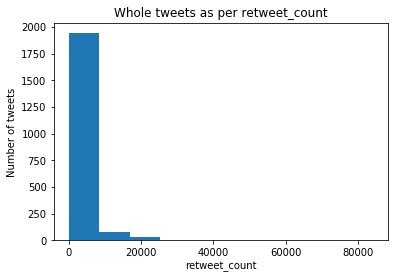

In [88]:
plt = df.retweet_count.plot(kind='hist', title='Whole tweets as per retweet_count')
plt.set_xlabel("retweet_count")
plt.set_ylabel("Number of tweets")
plt

 * In the first histogram, we observed that small number of tweet have big retweet_count.
 * it seems that most of tweets's retweet_count is smaller than 10000
 * To observe more detail, regarding frequency of retweet_count, they are divided into two groups
  * df.retweet_count<10000 , 1970 tweets are belong here
   * this group is gradually descreasing as per retwee_count then other group
  * df.retweet_count>=10000, only 98 tweets are belong here
   * this group is descreasing extremely as per retwee_count then other group

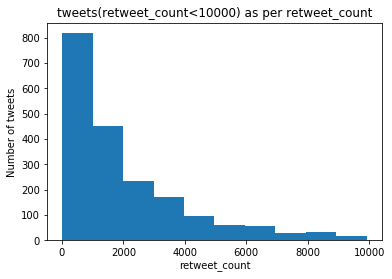

In [82]:
plt = df[df.retweet_count<10000].retweet_count.plot(kind='hist', title='tweets(retweet_count<10000) as per retweet_count')
plt.set_xlabel("retweet_count")
plt.set_ylabel("Number of tweets")
plt

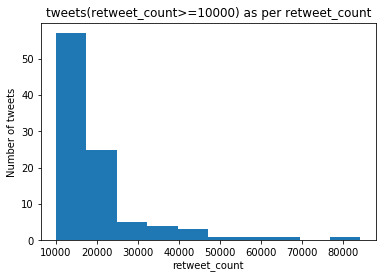

In [83]:
plt = df[df.retweet_count>=10000].retweet_count.plot(kind='hist', title='tweets(retweet_count>=10000) as per retweet_count')
plt.set_xlabel("retweet_count")
plt.set_ylabel("Number of tweets")
plt

In [27]:
df[df.retweet_count < 10000].retweet_count.describe()

count    1970.000000
mean     2013.915228
std      2016.279232
min        12.000000
25%       581.250000
50%      1245.500000
75%      2832.750000
max      9917.000000
Name: retweet_count, dtype: float64

In [28]:
df[df.retweet_count >= 10000].retweet_count.describe()

count       98.000000
mean     19117.785714
std      12165.174540
min      10047.000000
25%      11463.250000
50%      15841.000000
75%      18972.500000
max      84240.000000
Name: retweet_count, dtype: float64

## #2 insights
* To know tweet's distribution as per retwee_count and favorite_count, and also I hope to know regarding correlation coefficient between them
 * According scatter plot of retweet_count/favorite_count, they have positive relationship
 * 0.85 is correlation coefficiency value

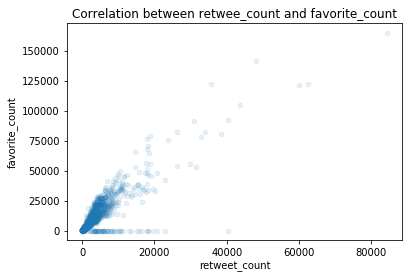

In [85]:
df.plot.scatter(x='retweet_count',
                y='favorite_count', alpha=0.1,
                title='Correlation between retwee_count and favorite_count')

In [19]:
df.retweet_count.corr(df.favorite_count)

0.8560484868962263

## #3 insights
* If tweet is recognized as doggo, floofer, pupper or puppo, theses tweet's retwee_count and favorite_count are higher than other?
* Correlation coefficient between retwee_count and favorite_count as per doggo, floofer, pupper or puppo
 * Two groups are defined like below, and they have similar correlation coefficient
 * One group have at least one doggo, floofer, pupper or puppo
  * 0.87
 * The group have none of doggo, floofer, pupper and puppo
  * 0.87
* Conclusion is that If tweet is recognized as doggo, floofer, pupper or puppo, retwee_count and favorite_count are not differnt with other tweets
 * Even correlation coefficient of two groups are same as 0.87, distribution/shape of scatter plot might be different.
 * However, distribution/shape of scatter plot from two groups are similar

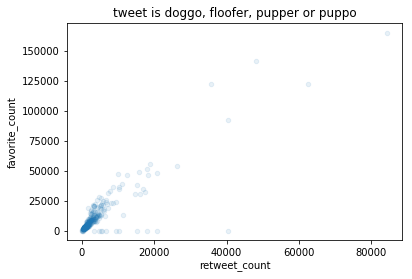

In [90]:
df_not_none = df[(df.doggo == 'doggo') | (df.floofer == 'floofer') | (df.pupper == 'pupper') | (df.puppo == 'puppo')]
df_not_none.plot.scatter(x='retweet_count',
                y='favorite_count', alpha=0.1,
                title='tweet is doggo, floofer, pupper or puppo')

In [11]:
df_not_none.retweet_count.corr(df_not_none.favorite_count)

0.8781964836140446

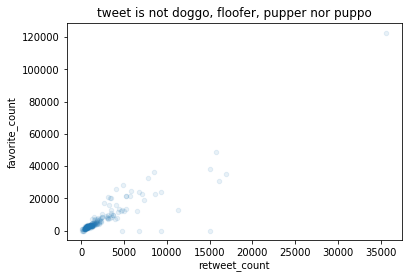

In [89]:
df_none = df[(df.doggo == 'None') & (df.floofer == 'None') & (df.pupper == 'pupper') & (df.puppo == 'None')]
df_none.plot.scatter(x='retweet_count', 
                     y='favorite_count',
                     alpha=0.1,
                     title='tweet is not doggo, floofer, pupper nor puppo')

In [13]:
df_none.retweet_count.corr(df_none.favorite_count)

0.8797800590698425